# 05 — Base ML Model Training und Berichte

## Ziel
Dieses Notebook  führt die Modellierung der Spotify-Daten durch und erstellt Berichte zur Bewertung der Modellleistung.
Am Ende erzeugen wir:
- Verschiedene trainierte ML-Modelle zur Vorhersage, Clustering oder andere Aufgaben
- Einen Bericht zur Bewertung der Modellleistung

## Imports und Setup

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.helper_functions import sklearn_sanitize_df
from sklearn.preprocessing import FunctionTransformer
import importlib
import utils.paths as paths

import json
from typing import Dict


from utils.preprocess import  (
build_preprocessor_tree,
build_preprocessor_linear
)

from utils.config import RANDOM_SEED
from xgboost import XGBRegressor , XGBClassifier , XGBRanker
from sklearn.metrics import ndcg_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,roc_auc_score, average_precision_score,f1_score


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from joblib import dump

from utils.config import (
    K_CLUSTERS,
TOP_K_GENRES,
TSNE_SAMPLE_MAX,
ALLOW_LEAKY_FEATURES,
HIT_PERCENTILE,
HIT_FALLBACK_POP_THRESHOLD,
MAIN_ALBUM_STRATEGY,
PAST_M,
MIN_PAST_TRACKS,
FUTURE_M,
BREAKOUT_Q,
)
from utils.kmeans import kmeans_compat
from utils.helper_functions import  safe_get,top_k_list_counts,classification_report_binary,best_f1_threshold

importlib.reload(paths)

SAMPLE_NAME = paths.load_sample_name()
PATHS = paths.make_paths(SAMPLE_NAME)
paths.ensure_dirs(PATHS)

RUN_META = paths.build_run_meta(
    PATHS,
    random_seed=RANDOM_SEED,
    allow_leaky_features=ALLOW_LEAKY_FEATURES,
    main_album_strategy=MAIN_ALBUM_STRATEGY,
)

MOOD_TAGS = [
    ("energetic", "energy", 0.75, "gt"),
    ("danceable", "danceability", 0.75, "gt"),
    ("acoustic", "acousticness", 0.75, "gt"),
    ("instrumental", "instrumentalness", 0.75, "gt"),
    ("happy", "valence", 0.75, "gt"),
    ("sad", "valence", 0.25, "lt"),
    ("chill", "energy", 0.25, "lt"),
]


## Globale Daten und Einstellungen

In [94]:
from sklearn.preprocessing import FunctionTransformer
import pandas as pd

# -------------------------
# Sanitize Transformer (für sklearn Pipelines)
# -------------------------
sanitize_tf = FunctionTransformer(sklearn_sanitize_df, feature_names_out="one-to-one")

# -------------------------
# Modeling tables (unchanged)
# -------------------------
track_df = pd.read_parquet(PATHS.input_targets_path / "track_dataset_full.parquet")
artist_df = pd.read_parquet(PATHS.input_targets_path / "artist_dataset_full.parquet")
album_df = pd.read_parquet(PATHS.input_targets_path / "album_dataset_full.parquet")

# -------------------------
# Full track feature table
# -------------------------
X_track = pd.read_parquet(PATHS.input_targets_path / "X_track_full.parquet")

# -------------------------
# (A) Success Percentile within Cohort
# -------------------------
y_success_pct = (pd.read_parquet(PATHS.input_targets_path / "y_success_pct.parquet").squeeze("columns"))

# -------------------------
# (B) Success Residual within Cohort
# -------------------------
y_success_residual = pd.read_parquet(PATHS.input_targets_path / "y_success_residual.parquet").squeeze("columns")

# -------------------------
# (C) Hit Prediction
# -------------------------
y_hit = pd.read_parquet(PATHS.input_targets_path / "y_hit.parquet").squeeze("columns")


# -------------------------
# (F) Artist Trajectory / Panel
# -------------------------
artist_panel = pd.read_parquet(PATHS.input_targets_path / "artist_panel.parquet")

Y_mood = pd.read_parquet(PATHS.input_targets_path / "Y_mood.parquet")

# -------------------------
# Genre Multi-Hot (DF behalten)
# -------------------------
track_genre_df = pd.read_parquet(PATHS.input_targets_path / "track_genre_multihot.parquet")
artist_genre_df = pd.read_parquet(PATHS.input_targets_path / "artist_genre_multihot.parquet")
album_genre_df = pd.read_parquet(PATHS.input_targets_path / "album_genre_multihot.parquet")


#### Task-specific TRACK matrices mit extra Guards

In [95]:
# -----------------------------
# Guards: required objects
# -----------------------------
required = ["X_track", "track_df", "y_success_pct", "y_success_residual", "y_hit", "Y_mood"]
missing = [r for r in required if r not in globals()]
assert not missing, f"Missing required variables: {missing}"

# Align base indices (important if something got reset earlier)
common_idx_track = X_track.index.intersection(track_df.index) \
    .intersection(y_success_pct.index) \
    .intersection(y_success_residual.index) \
    .intersection(y_hit.index) \
    .intersection(Y_mood.index)

X_track_aligned = X_track.loc[common_idx_track]
track_df_aligned = track_df.loc[common_idx_track]
y_success_pct_aligned = y_success_pct.loc[common_idx_track]
y_success_residual_aligned = y_success_residual.loc[common_idx_track]
y_hit_aligned = y_hit.loc[common_idx_track]
Y_mood_aligned = Y_mood.loc[common_idx_track]

# -----------------------------
# (A) Success Percentile within Cohort
# -----------------------------
mask_success_pct = y_success_pct_aligned.notna()
X_track_success_pct = X_track_aligned.loc[mask_success_pct].reset_index(drop=True)
y_success_pct_clean = y_success_pct_aligned.loc[mask_success_pct].reset_index(drop=True)

# -----------------------------
# (B) Success Residual within Cohort
# -----------------------------
mask_success_resid = y_success_residual_aligned.notna()
X_track_success_resid = X_track_aligned.loc[mask_success_resid].reset_index(drop=True)
y_success_residual_clean = y_success_residual_aligned.loc[mask_success_resid].reset_index(drop=True)

# -----------------------------
# (C) Hit prediction
# (If your features already exclude popularity proxies, this is safe)
# We'll still keep NA filtering consistent with popularity availability
# -----------------------------
mask_hit = y_hit_aligned.notna()
X_track_hit = X_track_aligned.loc[mask_hit].reset_index(drop=True)
y_hit_clean = y_hit_aligned.loc[mask_hit].reset_index(drop=True)

# -----------------------------
# (E) Mood prediction
# require audio features available (if the column exists)
# -----------------------------
if "has_audio_features" in track_df_aligned.columns:
    mask_mood = (pd.to_numeric(track_df_aligned["has_audio_features"], errors="coerce").fillna(0) == 1)
else:
    # fallback: if audio cols exist in X, we allow all rows
    mask_mood = pd.Series(True, index=track_df_aligned.index)

# also require at least one mood label (optional but usually helpful)
X_track_mood = X_track_aligned.loc[mask_mood].copy()
Y_mood_clean = Y_mood_aligned.loc[mask_mood].copy()

# Optional: drop rows with no mood labels (often improves learning)
DROP_EMPTY_MOOD_ROWS = True
if DROP_EMPTY_MOOD_ROWS:
    mask_has_any = (Y_mood_clean.sum(axis=1) > 0)
    X_track_mood = X_track_mood.loc[mask_has_any]
    Y_mood_clean = Y_mood_clean.loc[mask_has_any]

X_track_mood = X_track_mood.reset_index(drop=True)
Y_mood_clean = Y_mood_clean.reset_index(drop=True)

# -----------------------------
# Artist Trajectory datasets (F)
# -----------------------------
if "artist_panel" in globals() and isinstance(artist_panel, pd.DataFrame):
    # feature/target alignment: remove leakage columns later in feature selection
    assert "y_growth" in artist_panel.columns and "y_breakout" in artist_panel.columns, \
        "artist_panel must contain y_growth and y_breakout."
    X_artist_panel = artist_panel.copy().reset_index(drop=True)
    y_artist_growth_clean = artist_panel["y_growth"].astype("float64").reset_index(drop=True)
    y_artist_breakout_clean = artist_panel["y_breakout"].astype("int8").reset_index(drop=True)
else:
    X_artist_panel = None
    y_artist_growth_clean = None
    y_artist_breakout_clean = None

# -----------------------------
# Debug prints
# -----------------------------
print("TRACK TASK DATASETS:")
print(" - success_pct:", X_track_success_pct.shape, y_success_pct_clean.shape)
print(" - success_residual:", X_track_success_resid.shape, y_success_residual_clean.shape)
print(" - hit:", X_track_hit.shape, y_hit_clean.shape)
print(" - mood:", X_track_mood.shape, Y_mood_clean.shape)

print("\nARTIST TASK DATASETS:")
if X_artist_panel is None:
    print(" - artist_panel: not available")
else:
    print(" - artist_panel:", X_artist_panel.shape, y_artist_growth_clean.shape, y_artist_breakout_clean.shape)
    print(" - breakout rate:", float(y_artist_breakout_clean.mean()))


TRACK TASK DATASETS:
 - success_pct: (294454, 25) (294454,)
 - success_residual: (294454, 25) (294454,)
 - hit: (300000, 25) (300000,)
 - mood: (258042, 25) (258042, 7)

ARTIST TASK DATASETS:
 - artist_panel: (969, 17) (969,) (969,)
 - breakout rate: 0.19504643962848298


#### Mood Label Leakage Guard

In [96]:
# ------------------------------------------------------------
# Mood-task leakage guard
# ------------------------------------------------------------

# These audio features are the DIRECT source of the mood labels.
# Keeping them would allow the model to trivially reconstruct the labels.
MOOD_LABEL_SOURCE_AUDIO = [
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "liveness",
    "speechiness",
    "valence",
    "loudness",
    "tempo",
    "key",
    "mode",
    "time_signature",
]

# Apply only to mood task
X_track_mood = X_track_mood.drop(
    columns=[c for c in MOOD_LABEL_SOURCE_AUDIO if c in X_track_mood.columns],
    errors="ignore"
)

print("Mood features after leakage guard:", X_track_mood.shape)

Mood features after leakage guard: (258042, 13)


### Train: (A) Success Percentile within Cohort (Cohort-relative Success Scoring)

In diesem Schritt trainieren wir ein Modell, das die **relative Erfolgsposition** eines Tracks innerhalb seiner
Release-Kohorte vorhersagt. Statt absolute Popularity zu modellieren, nutzen wir ein kohorten-normalisiertes Target
(`success_pct_in_cohort`), das zeitliche Verzerrungen (z. B. Katalogwachstum, Popularity-Drift) reduziert.

**Warum?**
- Vergleiche über Zeiträume hinweg werden fairer (weniger Zeit-Bias).
- Liefert ein robustes „Success-Scoring“, das für Discovery/Ranking und als Input für Recommender geeignet ist.
- Ergänzt Learning-to-Rank: Neben Ranking kann auch ein stabiler **Score** gelernt werden.

**Wie?**
- Target: `success_pct_in_cohort = rank_pct(popularity within cohort) * 100`
- Split: zeitbasiert nach `cohort_ym` (Train/Val/Test) → verhindert Leakage.
- Modell: Gradient Boosting (XGBoost) für tabellarische Features.


In [97]:
# -------------------------
# Build meta aligned with X/y (IMPORTANT)
# Recreate same selection used for X_track_success_pct:
# mask_success_pct = y_success_pct.notna()
# -------------------------
base_idx = X_track.index.intersection(track_df.index).intersection(y_success_pct.index)
mask_success_pct = y_success_pct.loc[base_idx].notna()

meta_pct = track_df.loc[base_idx].loc[mask_success_pct].copy().reset_index(drop=True)

# Align X/y
X_pct = X_track_success_pct.reset_index(drop=True)
y_pct = pd.Series(y_success_pct_clean).reset_index(drop=True).astype(float)

assert len(X_pct) == len(y_pct) == len(meta_pct), "X/y/meta alignment mismatch."

# -------------------------
# Time split by cohort
# -------------------------
groups_sorted = np.sort(meta_pct["cohort_ym"].dropna().unique())

N_TEST = 6
N_VAL = 3
if len(groups_sorted) < (N_TEST + N_VAL + 1):
    raise ValueError(f"Not enough cohorts. Have {len(groups_sorted)}, need >= {N_TEST + N_VAL + 1}")

test_groups = groups_sorted[-N_TEST:]
val_groups = groups_sorted[-(N_TEST + N_VAL):-N_TEST]
train_groups = groups_sorted[:-(N_TEST + N_VAL)]

idx_tr = meta_pct["cohort_ym"].isin(train_groups).to_numpy()
idx_va = meta_pct["cohort_ym"].isin(val_groups).to_numpy()
idx_te = meta_pct["cohort_ym"].isin(test_groups).to_numpy()

Xtr, ytr = X_pct.loc[idx_tr], y_pct.loc[idx_tr]
Xva, yva = X_pct.loc[idx_va], y_pct.loc[idx_va]
Xte, yte = X_pct.loc[idx_te], y_pct.loc[idx_te]

print("Success% split shapes:", Xtr.shape, Xva.shape, Xte.shape)

# -------------------------
# Preprocess (same pipeline style you use elsewhere)
# -------------------------
pre_pct, _, _ = build_preprocessor_tree(X_pct)

Xtr_s = sklearn_sanitize_df(Xtr)
Xva_s = sklearn_sanitize_df(Xva)
Xte_s = sklearn_sanitize_df(Xte)

pre_pct.fit(Xtr_s)
Xtr_t = pre_pct.transform(Xtr_s)
Xva_t = pre_pct.transform(Xva_s)
Xte_t = pre_pct.transform(Xte_s)

# -------------------------
# Train model
# -------------------------
reg_pct = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=RANDOM_SEED if "RANDOM_SEED" in globals() else 42,
    n_jobs=1,
    device='cuda'
)

reg_pct.fit(
    Xtr_t, ytr.to_numpy(),
    eval_set=[(Xva_t, yva.to_numpy())],
    verbose=False
)

pred = reg_pct.predict(Xte_t)

# -------------------------
# Metrics
# -------------------------
success_pct_metrics = {
    "MAE": float(mean_absolute_error(yte, pred)),
    "RMSE": float(np.sqrt(mean_squared_error(yte, pred))),
    "R2": float(r2_score(yte, pred)),
    "n_train": int(len(ytr)),
    "n_val": int(len(yva)),
    "n_test": int(len(yte)),
    "label_range_expected": [0, 100],
}

print("TEST metrics (Success Percentile):", success_pct_metrics)

# Optional: save artifacts
try:
    from joblib import dump

    dump({"pre": pre_pct, "model": reg_pct}, PATHS.models_dir / "model_success_pct.joblib")
    print("Saved:", PATHS.models_dir / "model_success_pct.joblib")
except Exception as e:
    print("Skipping save:", e)

Success% split shapes: (288522, 25) (2977, 25) (2955, 25)
TEST metrics (Success Percentile): {'MAE': 21.37094827015172, 'RMSE': 25.644185605554664, 'R2': 0.20592434234800616, 'n_train': 288522, 'n_val': 2977, 'n_test': 2955, 'label_range_expected': [0, 100]}
Saved: C:\GitHub\uni-project-metrics-and-data\data\models\baseline\slice_001\model_success_pct.joblib


### Train: (B) Success Residual within Cohort (Overperformance Regression)

In diesem Schritt trainieren wir ein Regressionsmodell für **Overperformance**:
Statt absolute Popularity zu schätzen, sagt das Modell vorher, ob ein Track **über oder unter**
dem Durchschnitt seiner Release-Kohorte performt.

**Warum?**
- robuster gegenüber Zeitdrift und Popularity-Inflation
- identifiziert „Hidden Gems“ und Tracks, die stärker performen als ihr Umfeld erwarten lässt
- eignet sich gut als Scoring-Signal für Discovery/Curations

**Wie?**
- Target: `success_residual_in_cohort = popularity - mean(popularity within cohort)`
- Split: zeitbasiert nach `cohort_ym` (Train/Val/Test), um Leakage zu vermeiden
- Modell: Gradient Boosting (XGBoost) für tabellarische Features


In [98]:
# ============================================================
# ARTIST TRAJECTORY – TRAINING (Growth + Breakout) [ADJUSTED]
# Fixes included:
#  1) Build X AFTER sorting (prevents X/y row-mixing)
#  2) Time split changed from "last N months" -> "time-ordered fraction split"
#     (guarantees enough validation/test samples even if last months are sparse)
#  3) Growth target stabilization via log1p
#  4) Safe metrics handling when a split has only one class (breakout)
# ============================================================

import numpy as np
import pandas as pd

from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    roc_auc_score, average_precision_score
)

# -------------------------
# 0) Guards
# -------------------------
assert "artist_panel" in globals() and artist_panel is not None, "artist_panel not available."
assert isinstance(artist_panel, pd.DataFrame), "artist_panel must be a DataFrame."
assert "release_month_ts" in artist_panel.columns, "artist_panel needs 'release_month_ts'."
assert "y_growth" in artist_panel.columns and "y_breakout" in artist_panel.columns, \
    "artist_panel must contain y_growth and y_breakout."

# -------------------------
# 1) Sort FIRST (critical)
# -------------------------
artist_panel_sorted = (
    artist_panel
    .sort_values("release_month_ts")
    .reset_index(drop=True)
)

# -------------------------
# 2) Build features (drop leakage + IDs)
# -------------------------
drop_cols = {
    "y_growth", "y_breakout",
    # future-derived (leakage)
    "future_tracks", "future_pop_sum", "future_pop_mean",
    # optional: strong proxies (drop if you want stricter leakage avoidance)
    "pop_sum_month", "pop_mean_month", "pop_max_month",
}

id_like = [
    c for c in artist_panel_sorted.columns
    if c.endswith("_id") or c in ["artist_id", "main_artist_id", "ARTIST_COL"]
]
drop_cols |= set(id_like)

feature_cols = [
    c for c in artist_panel_sorted.columns
    if c not in drop_cols
       and c not in ["release_month_ts", "year"]
       and pd.api.types.is_numeric_dtype(artist_panel_sorted[c])
]

if len(feature_cols) == 0:
    raise ValueError("No numeric feature columns found for artist trajectory after dropping leakage/IDs.")

X = (
    artist_panel_sorted[feature_cols]
    .apply(pd.to_numeric, errors="coerce")
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
)

y_growth = (
    pd.to_numeric(artist_panel_sorted["y_growth"], errors="coerce")
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
    .to_numpy(dtype=np.float64)
)

y_break = (
    pd.to_numeric(artist_panel_sorted["y_breakout"], errors="coerce")
    .fillna(0)
    .astype(np.int8)
    .to_numpy()
)

# -------------------------
# 3) Time-ordered FRACTION split (robust even if last months are sparse)
# -------------------------
n = len(artist_panel_sorted)

# Minimum sizes so metrics are meaningful
MIN_TEST = 50
MIN_VAL = 50

n_test = max(MIN_TEST, int(0.15 * n))
n_val = max(MIN_VAL, int(0.10 * n))
n_train = n - n_val - n_test

if n_train <= 0:
    raise ValueError(f"Not enough samples for split: n={n}, n_train={n_train}, n_val={n_val}, n_test={n_test}")

idx_tr = np.arange(0, n_train)
idx_va = np.arange(n_train, n_train + n_val)
idx_te = np.arange(n_train + n_val, n)

Xtr, Xva, Xte = X.iloc[idx_tr], X.iloc[idx_va], X.iloc[idx_te]
ytr_g, yva_g, yte_g = y_growth[idx_tr], y_growth[idx_va], y_growth[idx_te]
ytr_b, yva_b, yte_b = y_break[idx_tr], y_break[idx_va], y_break[idx_te]

print("Artist trajectory split:", Xtr.shape, Xva.shape, Xte.shape)
print("Breakout positives (train/val/test):", int(ytr_b.sum()), int(yva_b.sum()), int(yte_b.sum()))
print("Breakout rates (train/val/test):", float(ytr_b.mean()), float(yva_b.mean()), float(yte_b.mean()))

# -------------------------
# 4) Growth regression (log1p target)
# -------------------------
ytr_g_log = np.log1p(np.clip(ytr_g, a_min=0, a_max=None))
yva_g_log = np.log1p(np.clip(yva_g, a_min=0, a_max=None))
yte_g_log = np.log1p(np.clip(yte_g, a_min=0, a_max=None))

reg = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=RANDOM_SEED if "RANDOM_SEED" in globals() else 42,
    n_jobs=1,
    device="cuda",
)

reg.fit(Xtr, ytr_g_log, eval_set=[(Xva, yva_g_log)], verbose=False)
pred_g_log = reg.predict(Xte)

growth_metrics = {
    "MAE_log": float(mean_absolute_error(yte_g_log, pred_g_log)),
    "RMSE_log": float(np.sqrt(mean_squared_error(yte_g_log, pred_g_log))),
    "R2_log": float(r2_score(yte_g_log, pred_g_log)),
    # Optional raw-space reporting
    "MAE_raw": float(mean_absolute_error(yte_g, np.expm1(pred_g_log))),
    "RMSE_raw": float(np.sqrt(mean_squared_error(yte_g, np.expm1(pred_g_log)))),
}
print("Growth metrics:", growth_metrics)

# -------------------------
# 5) Breakout classification
# -------------------------
pos_rate = float(ytr_b.mean())
scale_pos_weight = (1.0 - pos_rate) / (pos_rate + 1e-9)

clf = XGBClassifier(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    tree_method="hist",
    random_state=RANDOM_SEED if "RANDOM_SEED" in globals() else 42,
    n_jobs=1,
    device="cuda",
)

clf.fit(Xtr, ytr_b, eval_set=[(Xva, yva_b)], verbose=False)
proba = clf.predict_proba(Xte)[:, 1]

if len(np.unique(yte_b)) < 2:
    roc_auc = None
    pr_auc = None
else:
    roc_auc = float(roc_auc_score(yte_b, proba))
    pr_auc = float(average_precision_score(yte_b, proba))

breakout_metrics = {
    "ROC_AUC": roc_auc,
    "PR_AUC": pr_auc,
    "breakout_rate_test": float(yte_b.mean()),
    "n_test": int(len(yte_b)),
}
print("Breakout metrics:", breakout_metrics)

# Export for your report/metrics dict
artist_growth_metrics = growth_metrics
artist_breakout_metrics = breakout_metrics


Artist trajectory split: (728, 7) (96, 7) (145, 7)
Breakout positives (train/val/test): 149 15 25
Breakout rates (train/val/test): 0.20467032967032966 0.15625 0.1724137931034483
Growth metrics: {'MAE_log': 0.5320305517300312, 'RMSE_log': 0.8236676615356225, 'R2_log': -0.5166338994646391, 'MAE_raw': 1.6703357296139891, 'RMSE_raw': 4.88928551104694}
Breakout metrics: {'ROC_AUC': 0.39266666666666666, 'PR_AUC': 0.1501898855969802, 'breakout_rate_test': 0.1724137931034483, 'n_test': 145}


### Train: Artist Trajectory Model (Growth + Breakout)

In diesem Schritt trainieren wir ein **zeitbewusstes Artist-Trajectory-Modell**, das zukünftige Entwicklung von Künstlern prognostiziert.
Das Ziel ist nicht „wer ist jetzt populär“, sondern **wer wächst als Nächstes**.

**Targets**
- **Growth (Regression):** erwartetes Wachstum über einen festen Horizont
  $$ (\Delta = \text{future\_mean\_pop} - \text{past\_mean\_pop}) $$
- **Breakout (Klassifikation):** 1, wenn der Artist im **Top-X%** der Wachstumswerte liegt (innerhalb des Jahres)

**Warum?**
- Robust gegen Zeit-Bias (Katalog wächst, Popularity driftet).
- Nützlich für „Artists to Watch“, Playlist-Curation und A&R/Trend-Analysen.

**Wie?**
- Wir nutzen eine **Artist-Month Panel-Tabelle** mit Rolling-Window-Features (nur Vergangenheit).
- Split erfolgt **zeitlich** (Train/Val/Test nach Monaten), um Leakage zu vermeiden.
- Modelle: Gradient-Boosting (z. B. XGBoost) für Regression und Klassifikation.



In [99]:

# ============================================================
# ARTIST TRAJECTORY – TRAINING (Growth + Breakout) [FIXED]
# Fixes included:
#  1) Build X AFTER sorting (prevents X/y row-mixing)
#  2) Robust numeric casting + NA handling
#  3) Growth target stabilization via log1p (reduces extreme negative R²)
#  4) Safe metrics when a split has only one class for breakout
# ============================================================

import numpy as np
import pandas as pd

from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    roc_auc_score, average_precision_score
)

# -------------------------
# 0) Basic guards
# -------------------------
assert "artist_panel" in globals() and artist_panel is not None, "artist_panel not available."
assert isinstance(artist_panel, pd.DataFrame), "artist_panel must be a DataFrame."
assert "release_month_ts" in artist_panel.columns, "artist_panel needs 'release_month_ts'."
assert "y_growth" in artist_panel.columns and "y_breakout" in artist_panel.columns, \
    "artist_panel must contain y_growth and y_breakout."

# -------------------------
# 1) Sort FIRST (critical for correct temporal alignment)
# -------------------------
artist_panel_sorted = (
    artist_panel
    .sort_values("release_month_ts")
    .reset_index(drop=True)
)

# -------------------------
# 2) Build feature matrix (drop leakage + IDs)
# -------------------------
drop_cols = {
    "y_growth", "y_breakout",
    # future-derived (leakage)
    "future_tracks", "future_pop_sum", "future_pop_mean",
    # optional: strong proxies (keep dropped if they correlate too directly)
    "pop_sum_month", "pop_mean_month", "pop_max_month",
}

# Remove ID-like columns from features
id_like = [
    c for c in artist_panel_sorted.columns
    if c.endswith("_id") or c in ["artist_id", "main_artist_id", "ARTIST_COL"]
]
drop_cols |= set(id_like)

# Use only numeric feature columns (excluding time keys)
feature_cols = [
    c for c in artist_panel_sorted.columns
    if c not in drop_cols
       and c not in ["release_month_ts", "year"]
       and pd.api.types.is_numeric_dtype(artist_panel_sorted[c])
]

if len(feature_cols) == 0:
    raise ValueError("No numeric feature columns found for artist trajectory after dropping leakage/IDs.")

X = (
    artist_panel_sorted[feature_cols]
    .apply(pd.to_numeric, errors="coerce")
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
)

# Targets
y_growth = (
    pd.to_numeric(artist_panel_sorted["y_growth"], errors="coerce")
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
    .to_numpy(dtype=np.float64)
)
y_break = (
    pd.to_numeric(artist_panel_sorted["y_breakout"], errors="coerce")
    .fillna(0)
    .astype(np.int8)
    .to_numpy()
)

# -------------------------
# 3) Time split (last months as test)
# -------------------------
months = artist_panel_sorted["release_month_ts"].dropna().sort_values().unique()

N_TEST_MONTHS = 6
N_VAL_MONTHS = 3

if len(months) < (N_TEST_MONTHS + N_VAL_MONTHS + 1):
    raise ValueError(
        f"Not enough months for time split. Have {len(months)}, need >= {N_TEST_MONTHS + N_VAL_MONTHS + 1}.")

test_months = months[-N_TEST_MONTHS:]
val_months = months[-(N_TEST_MONTHS + N_VAL_MONTHS):-N_TEST_MONTHS]
train_months = months[:-(N_TEST_MONTHS + N_VAL_MONTHS)]

idx_tr = artist_panel_sorted["release_month_ts"].isin(train_months).to_numpy()
idx_va = artist_panel_sorted["release_month_ts"].isin(val_months).to_numpy()
idx_te = artist_panel_sorted["release_month_ts"].isin(test_months).to_numpy()

Xtr, Xva, Xte = X.loc[idx_tr], X.loc[idx_va], X.loc[idx_te]
ytr_g, yva_g, yte_g = y_growth[idx_tr], y_growth[idx_va], y_growth[idx_te]
ytr_b, yva_b, yte_b = y_break[idx_tr], y_break[idx_va], y_break[idx_te]

print("Artist trajectory split:", Xtr.shape, Xva.shape, Xte.shape)
print("Breakout positives (train/val/test):", int(ytr_b.sum()), int(yva_b.sum()), int(yte_b.sum()))
print("Breakout rates (train/val/test):", float(ytr_b.mean()), float(yva_b.mean()), float(yte_b.mean()))

# -------------------------
# 4) Growth regression (stabilize target: log1p)
# -------------------------
# Growth targets are often heavy-tailed -> log transform improves stability
ytr_g_log = np.log1p(np.clip(ytr_g, a_min=0, a_max=None))
yva_g_log = np.log1p(np.clip(yva_g, a_min=0, a_max=None))
yte_g_log = np.log1p(np.clip(yte_g, a_min=0, a_max=None))

reg = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=RANDOM_SEED if "RANDOM_SEED" in globals() else 42,
    n_jobs=1,
    device="cuda",
)

reg.fit(Xtr, ytr_g_log, eval_set=[(Xva, yva_g_log)], verbose=False)
pred_g_log = reg.predict(Xte)

growth_metrics = {
    "MAE_log": float(mean_absolute_error(yte_g_log, pred_g_log)),
    "RMSE_log": float(np.sqrt(mean_squared_error(yte_g_log, pred_g_log))),
    "R2_log": float(r2_score(yte_g_log, pred_g_log)),
    # Optional: report in original space too (more intuitive, but less stable)
    "MAE_raw": float(mean_absolute_error(yte_g, np.expm1(pred_g_log))),
    "RMSE_raw": float(np.sqrt(mean_squared_error(yte_g, np.expm1(pred_g_log)))),
}
print("Growth metrics:", growth_metrics)

# -------------------------
# 5) Breakout classification (safe AUC handling)
# -------------------------
pos_rate = float(ytr_b.mean())
scale_pos_weight = (1.0 - pos_rate) / (pos_rate + 1e-9)

clf = XGBClassifier(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    tree_method="hist",
    random_state=RANDOM_SEED if "RANDOM_SEED" in globals() else 42,
    n_jobs=1,
    device="cuda",
)

clf.fit(Xtr, ytr_b, eval_set=[(Xva, yva_b)], verbose=False)
proba = clf.predict_proba(Xte)[:, 1]

# If test split has only one class, ROC/PR AUC are undefined
if len(np.unique(yte_b)) < 2:
    roc_auc = None
    pr_auc = None
else:
    roc_auc = float(roc_auc_score(yte_b, proba))
    pr_auc = float(average_precision_score(yte_b, proba))

breakout_metrics = {
    "ROC_AUC": roc_auc,
    "PR_AUC": pr_auc,
    "breakout_rate_test": float(yte_b.mean()),
    "n_test": int(len(yte_b)),
}
print("Breakout metrics:", breakout_metrics)

# Export for your report cell
artist_growth_metrics = growth_metrics
artist_breakout_metrics = breakout_metrics


Artist trajectory split: (960, 7) (3, 7) (6, 7)
Breakout positives (train/val/test): 186 1 2
Breakout rates (train/val/test): 0.19375 0.3333333333333333 0.3333333333333333
Growth metrics: {'MAE_log': 2.795519891195775, 'RMSE_log': 2.827453398006532, 'R2_log': -170.92914781927996, 'MAE_raw': 22.08464903177358, 'RMSE_raw': 22.729516591464357}
Breakout metrics: {'ROC_AUC': 0.0, 'PR_AUC': 0.26666666666666666, 'breakout_rate_test': 0.3333333333333333, 'n_test': 6}


### Train: Top-K Recommender (Learning-to-Rank)

In diesem Schritt trainieren wir ein **Top-K Recommender-Modell** auf Basis von
**Learning-to-Rank**, um Tracks **relativ zueinander** zu bewerten statt absolute
Vorhersagen zu treffen.

#### Motivation
Klassische Regressionsmodelle (z. B. Popularity-Vorhersage) sind für
Empfehlungssysteme oft ungeeignet, da:
- Popularity stark skaliert und zeitabhängig ist,
- absolute Scores weniger relevant sind als **relative Reihenfolgen**,
- Nutzer- und Playlist-Szenarien fast immer ein **Top-K Ranking** benötigen.

Ein Ranking-Modell beantwortet stattdessen die Frage:
> *Welche Tracks sollten innerhalb eines gegebenen Kontexts weiter oben stehen?*

#### Trainingsziel
Als Zielvariable verwenden wir ein **kohortenrelatives Erfolgsmaß**, z. B.:

- **Success Percentile within Cohort** *(A)*
  → ordnet Tracks nach ihrer relativen Performance innerhalb desselben Release-Zeitfensters

oder alternativ:
- **Success Residual within Cohort** *(B)*
  → belohnt Tracks, die **besser als der Durchschnitt ihrer Kohorte** performen

Diese Targets sind robust gegenüber:
- Release-Zeit-Bias
- Katalogwachstum
- Popularity-Inflation über Jahre hinweg

#### Modelltyp
Wir verwenden ein **Gradient-Boosted Learning-to-Rank Modell** (z. B. `XGBRanker`):

- Eingabe: Track-Features (`X_track`)
- Gruppierung: **Cohorts** (z. B. Release-Monat oder -Jahr)
- Ausgabe: ein **Ranking-Score** pro Track

Das Modell lernt explizit, **korrekte Paar- und Gruppenordnungen** zu optimieren,
statt einzelne Zielwerte zu approximieren.

#### Ergebnis
Das trainierte Modell ermöglicht:
- **Top-K Track Empfehlungen** pro Kohorte
- „Trending-Track“ Listen ohne Nutzerhistorie
- robuste Rankings für Cold-Start-Szenarien

Die Modellqualität evaluieren wir mit ranking-spezifischen Metriken wie:
- NDCG@K
- Hit-Rate@K
- Mean Reciprocal Rank (MRR)

Dieses Recommender-Modell bildet die Grundlage für alle
**ranking-basierten Empfehlungsszenarien** im Projekt.


In [100]:
# ============================================================
# TOP-K RECOMMENDER (Learning-to-Rank) – WORKING SAFE CELL
# Fixes:
#  - XGBRanker requires integer relevance labels
#  - With exp NDCG gain, relevance must be <= 31
#  - Meta/X/y alignment rebuilt from the same mask used for X_track_success_pct
# ============================================================

import numpy as np
import pandas as pd
from xgboost import XGBRanker
from sklearn.metrics import ndcg_score

# -------------------------
# 0) Ensure y objects are Series (loaded with squeeze in your loading cell)
#    If they are still 1-col DFs, squeeze them here.
# -------------------------
if isinstance(y_success_pct_clean, pd.DataFrame):
    y_success_pct_clean = y_success_pct_clean.squeeze("columns")
if isinstance(y_success_pct, pd.DataFrame):
    y_success_pct = y_success_pct.squeeze("columns")

# -------------------------
# 1) Rebuild meta with EXACT SAME mask used to build X_track_success_pct
#    mask = y_success_pct.notna() on aligned base_idx
# -------------------------
base_idx = X_track.index.intersection(track_df.index).intersection(y_success_pct.index)

mask = y_success_pct.loc[base_idx].notna()  # Series[bool] ✅ 1D
meta_rank = track_df.loc[base_idx].loc[mask].copy().reset_index(drop=True)

# -------------------------
# 2) Align X and y with meta
# -------------------------
X_rank = X_track_success_pct.reset_index(drop=True)
y_rank = y_success_pct_clean.reset_index(drop=True).astype(float)

assert len(X_rank) == len(y_rank) == len(meta_rank), "X/y/meta alignment mismatch."
assert "cohort_ym" in meta_rank.columns, "meta_rank needs cohort_ym."

# -------------------------
# 3) Convert continuous success signal -> integer relevance grades in [0..31]
#    Recommended: qcut into 32 bins (0..31), keeps ordering + stable for ranking.
# -------------------------
# qcut can produce <32 bins if many ties; that's fine (still <=31).
y_rel = pd.qcut(
    y_rank,
    q=32,
    labels=False,
    duplicates="drop"
).astype(np.int32).to_numpy()

# Safety: guarantee non-negative and <=31
y_rel = np.clip(y_rel, 0, 31).astype(np.int32)

# -------------------------
# 4) Time split by cohort
# -------------------------
groups_sorted = np.sort(meta_rank["cohort_ym"].dropna().unique())
N_TEST, N_VAL = 6, 3

if len(groups_sorted) < (N_TEST + N_VAL + 1):
    raise ValueError(f"Not enough cohorts. Have {len(groups_sorted)}, need >= {N_TEST + N_VAL + 1}")

test_groups = groups_sorted[-N_TEST:]
val_groups = groups_sorted[-(N_TEST + N_VAL):-N_TEST]
train_groups = groups_sorted[:-(N_TEST + N_VAL)]

idx_tr = meta_rank["cohort_ym"].isin(train_groups).to_numpy()
idx_va = meta_rank["cohort_ym"].isin(val_groups).to_numpy()
idx_te = meta_rank["cohort_ym"].isin(test_groups).to_numpy()

Xtr, ytr, mtr = X_rank.loc[idx_tr], y_rel[idx_tr], meta_rank.loc[idx_tr].copy()
Xva, yva, mva = X_rank.loc[idx_va], y_rel[idx_va], meta_rank.loc[idx_va].copy()
Xte, yte, mte = X_rank.loc[idx_te], y_rel[idx_te], meta_rank.loc[idx_te].copy()


# -------------------------
# 5) Sort each split by cohort + build group sizes
#    XGBRanker requires rows ordered by groups for the group array
# -------------------------
def sort_by_group(X, y, m, group_col="cohort_ym"):
    order = np.argsort(m[group_col].to_numpy())
    return (
        X.iloc[order].reset_index(drop=True),
        y[order],  # y is np.array
        m.iloc[order].reset_index(drop=True),
    )


Xtr, ytr, mtr = sort_by_group(Xtr, ytr, mtr)
Xva, yva, mva = sort_by_group(Xva, yva, mva)
Xte, yte, mte = sort_by_group(Xte, yte, mte)


def group_sizes(meta: pd.DataFrame, group_col="cohort_ym"):
    # meta must already be sorted by group_col
    return meta.groupby(group_col, sort=False).size().to_numpy()


gtr = group_sizes(mtr)
gva = group_sizes(mva)
gte = group_sizes(mte)

assert gtr.sum() == len(Xtr) and gva.sum() == len(Xva) and gte.sum() == len(Xte), "Group sum mismatch."

print("Ranking split shapes:", Xtr.shape, Xva.shape, Xte.shape)
print("Group counts train/val/test:", len(gtr), len(gva), len(gte))

# -------------------------
# 6) Preprocess + train ranker
# -------------------------
pre_rank, _, _ = build_preprocessor_tree(pd.concat([Xtr, Xva, Xte], axis=0))

Xtr_s = sklearn_sanitize_df(Xtr)
Xva_s = sklearn_sanitize_df(Xva)
Xte_s = sklearn_sanitize_df(Xte)

pre_rank.fit(Xtr_s)
Xtr_t = pre_rank.transform(Xtr_s)
Xva_t = pre_rank.transform(Xva_s)
Xte_t = pre_rank.transform(Xte_s)

ranker = XGBRanker(
    objective="rank:pairwise",
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=RANDOM_SEED,
    n_jobs=1,
    device="cuda",
    # NOTE: no need to set ndcg_exp_gain since we ensure labels <= 31
)

ranker.fit(
    Xtr_t, ytr,
    group=gtr,
    eval_set=[(Xva_t, yva)],
    eval_group=[gva],
    verbose=False
)

score_te = ranker.predict(Xte_t)


# -------------------------
# 7) Evaluate mean NDCG@K across cohorts
# -------------------------
def mean_ndcg_at_k(meta, y_true, y_score, k=10, group_col="cohort_ym"):
    vals = []
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    for _, idx in meta.groupby(group_col, sort=False).indices.items():
        idx = np.asarray(list(idx))
        if len(idx) < 2:
            continue
        kk = min(k, len(idx))
        vals.append(ndcg_score([y_true[idx]], [y_score[idx]], k=kk))
    return float(np.mean(vals)) if vals else float("nan")


ndcg10 = mean_ndcg_at_k(mte, yte, score_te, k=10)
ndcg20 = mean_ndcg_at_k(mte, yte, score_te, k=20)

print("TEST Ranking Metrics:")
print(" - NDCG@10:", ndcg10)
print(" - NDCG@20:", ndcg20)


Ranking split shapes: (288522, 25) (2977, 25) (2955, 25)
Group counts train/val/test: 961 3 6
TEST Ranking Metrics:
 - NDCG@10: 0.7270786717019949
 - NDCG@20: 0.7762712793433938



## Train: Hit Prediction (Binary Classification, XGBoost)

Ziel: Vorhersage, ob ein Track ein **Hit** ist (`0/1`).

### Warum XGBoost?
- Lernt komplexe Regeln (nichtlinear)
- Oft deutlich bessere PR-AUC/F1 bei “Hit”-ähnlichen Problemen

### Zwei wichtige Tricks
1. **Class Imbalance**: Wir setzen `scale_pos_weight`.
2. **Threshold-Tuning**: Wir wählen den Threshold, der den F1-Score maximiert.



In [101]:


# --- 0) Clean label ---
y_hit_clean = y_hit_clean.fillna(0).astype(int)

# --- 1) Strong anti-leak guard: never let any popularity-like column into HIT features ---
# (if your ALLOW_LEAKY_FEATURES is already False, this is still a safe extra guard)
leaky_cols = [c for c in X_track_hit.columns if "popularity" in c.lower()]
X_hit = X_track_hit.drop(columns=leaky_cols, errors="ignore")

# --- 2) Train / Val / Test split (threshold is chosen on VAL only!) ---
X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    X_hit, y_hit_clean,
    test_size=0.20, random_state=RANDOM_SEED, stratify=y_hit_clean
)
X_va, X_te, y_va, y_te = train_test_split(
    X_tmp, y_tmp,
    test_size=0.50, random_state=RANDOM_SEED, stratify=y_tmp
)

# --- 3) Preprocess: fit ONLY on train ---
pre_hit, _, _ = build_preprocessor_tree(X_hit)

X_tr_s = sklearn_sanitize_df(X_tr)
X_va_s = sklearn_sanitize_df(X_va)
X_te_s = sklearn_sanitize_df(X_te)

pre_hit.fit(X_tr_s)
Xtr_t = pre_hit.transform(X_tr_s)
Xva_t = pre_hit.transform(X_va_s)
Xte_t = pre_hit.transform(X_te_s)

# --- 4) Class imbalance weight (train only) ---
neg = int((y_tr == 0).sum())
pos = int((y_tr == 1).sum())
scale_pos_weight = neg / max(pos, 1)

# --- 5) Model + early stopping ---
hit_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    n_estimators=5000,  # high cap; early stopping finds the sweet spot
    learning_rate=0.05,
    max_depth=7,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    min_child_weight=1,
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",
    random_state=RANDOM_SEED,
    device="cuda",
    n_jobs=1,
)

hit_clf.fit(
    Xtr_t, y_tr,
    eval_set=[(Xva_t, y_va)],
    verbose=False,
)

# --- 6) Choose threshold on VAL (NOT test) ---
proba_va = hit_clf.predict_proba(Xva_t)[:, 1]
thr_hit, thr_hit_f1 = best_f1_threshold(y_va, proba_va)

# --- 7) Final evaluation on TEST using val-threshold ---
proba_te = hit_clf.predict_proba(Xte_t)[:, 1]
hit_metrics = classification_report_binary(y_te, proba_te, threshold=thr_hit)
hit_metrics["best_threshold"] = float(thr_hit)
hit_metrics["best_threshold_f1_on_val"] = float(thr_hit_f1)

# --- 8) Save a clean inference pipeline + threshold ---
pipe_hit = Pipeline(steps=[
    ("sanitize", sanitize_tf),
    ("pre", pre_hit),
    ("model", hit_clf),
])

dump(pipe_hit, PATHS.models_dir / "hit_pipeline_xgb.joblib")

hit_metrics


{'roc_auc': 0.6724023868938445,
 'pr_auc': 0.3424565098167982,
 'f1': 0.4019095805451281,
 'confusion_matrix': [[10417, 13395], [1263, 4925]],
 'best_threshold': 0.2,
 'best_threshold_f1_on_val': 0.40378188931453257}

### Train : Künstler-Clustering (Unsupervised)

Ziel: Künstler in **Segmente/Cluster** einteilen (z.B. für Exploration, Empfehlungen, Marketing-Personas oder später als Feature).

**Idee:** Kein Graph-Community-Detection (Louvain/Leiden), sondern **Feature-basiertes Clustering**.

**Pipeline (kurz):**
1) Artist-Features auswählen (Follower/Popularity/Katalog + Audio-Feature-Mittelwerte, optional Genre-Multi-Hot)
2) Fehlwerte imputieren (Median)
3) Skalieren (wichtig, weil Distanz-basiert)
4) PCA (stabiler/schneller für KMeans)
5) KMeans → `artist_df["cluster"]`
Optional: t-SNE nur als visuelle Diagnose auf einem Sample

**Outputs:**
- `artist_df["cluster"]`
- gespeicherte Artefakte: Preprocessing + PCA + KMeans (`artist_clustering.joblib`)
- Dataset mit Clustern als Parquet


In [102]:
# =========================
# Artist Clustering
# =========================

# 2) Artist-Level Features auswählen (nur sinnvolle numerische Features)
ARTIST_NUM = [
                 "popularity", "followers", "log_followers",
                 "n_tracks", "log_n_tracks",
                 "track_pop_mean", "explicit_rate",
             ] + [c for c in artist_df.columns if c.startswith("mean_")]  # z.B. mean_energy, mean_danceability, ...

X_artist_base = artist_df[ARTIST_NUM].copy()

# 3) Optional: Genre Multi-Hot anhängen (falls vorhanden)
if "artist_genre_mh" in globals() and isinstance(artist_genre_df, pd.DataFrame) and len(artist_genre_df.columns) > 0:
    X_artist = pd.concat(
        [X_artist_base.reset_index(drop=True), artist_genre_df.reset_index(drop=True)],
        axis=1
    )
else:
    X_artist = X_artist_base

# 4) Nur numerische Spalten fürs Clustering behalten (KMeans braucht numeric)
num_cols = [c for c in X_artist.columns if pd.api.types.is_numeric_dtype(X_artist[c])]
X_num = X_artist[num_cols].copy()

# 5) Preprocessing fürs Clustering: Impute + Scale
#    (Skalierung ist wichtig, weil KMeans distanzbasiert arbeitet.)
cluster_pre = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True)),  # hier OK, weil wir eine dichte Matrix nutzen
])

X_scaled = cluster_pre.fit_transform(X_num)

# 6) PCA: reduziert Dimensionalität → stabiler & schneller für KMeans
pca_components = min(30, X_scaled.shape[1])  # max 30 oder weniger, wenn weniger Features existieren
pca = PCA(n_components=pca_components, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_scaled)

# 7) KMeans Clustering
kmeans = kmeans_compat(n_clusters=K_CLUSTERS, random_state=RANDOM_SEED)
artist_clusters = kmeans.fit_predict(X_pca)

# Cluster-Label ins artist_df schreiben
artist_df["cluster"] = artist_clusters.astype(int)

SAMPLE_TSNE = min(TSNE_SAMPLE_MAX, len(artist_df))

# 9) Kleiner Report fürs metrics_report.json (damit es später nicht crasht)
artist_cluster_artifact = {
    "k": int(K_CLUSTERS),
    "n_artists": int(len(artist_df)),
    "n_features_used": int(X_num.shape[1]),
    "pca_components": int(pca_components),
    "pca_explained_variance_ratio_sum": float(np.sum(pca.explained_variance_ratio_)),
    "tsne_sample_n": int(SAMPLE_TSNE),
}

# 10) Artefakte speichern (für Notebook 4 / Wiederverwendung)
cluster_bundle = {
    "cluster_pre": cluster_pre,
    "pca": pca,
    "kmeans": kmeans,
    "numeric_columns_used": num_cols,
    "k": int(K_CLUSTERS),
}

dump(cluster_bundle, PATHS.models_dir / "artist_clustering.joblib")
artist_df.to_parquet(PATHS.modeling_dir / "artist_dataset_with_clusters.parquet", index=False)

artist_cluster_artifact


{'k': 30,
 'n_artists': 187440,
 'n_features_used': 16,
 'pca_components': 16,
 'pca_explained_variance_ratio_sum': 0.9999999999999999,
 'tsne_sample_n': 4000}

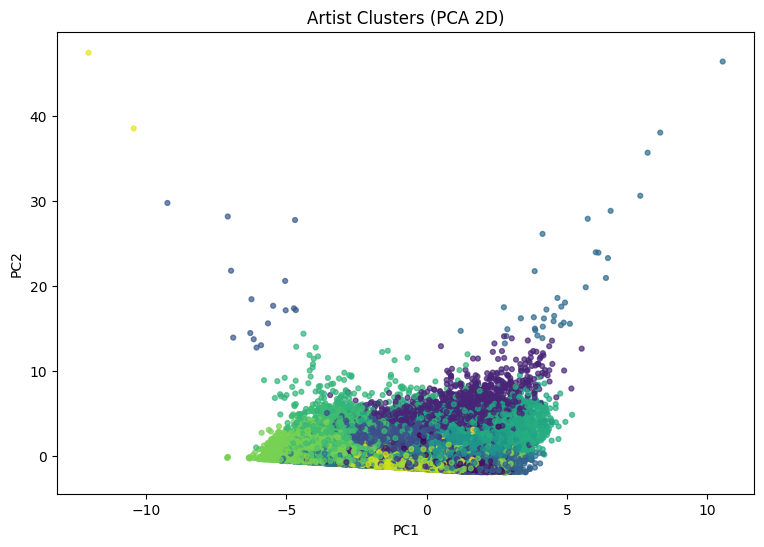

In [103]:
# 2D PCA nur für Visualisierung
pca2 = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca2 = pca2.fit_transform(X_scaled)

plt.figure(figsize=(9, 6))
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=artist_df["cluster"].values, s=12, alpha=0.7)
plt.title("Artist Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### Train: Track-to-Track Similarity (Unsupervised Embeddings)

In diesem Schritt trainieren wir ein **unüberwachtes Similarity-Modell**, um „**Songs wie dieser**“-Empfehlungen ohne Nutzerhistorie zu ermöglichen.
Dazu lernen wir pro Track einen kompakten **Embedding-Vektor** ausschließlich aus den **Audio-Features** (z. B. Energy, Danceability, Valence).

**Warum?**
- Kein User-Log notwendig → funktioniert auch im **Cold-Start**.
- Embeddings liefern eine **kontinuierliche „Vibe“-Repräsentation** (statt harter Genre-Labels).
- Ähnlichkeitssuche wird effizient: Top-K über **Cosine Similarity** im Embedding-Space.

**Wie?**
- Wir skalieren Audio-Features und trainieren einen **Autoencoder**:
  - Encoder komprimiert Features → Embedding
  - Decoder rekonstruiert die Original-Features
- Nach dem Training erzeugen wir Embeddings für alle Tracks und berechnen Ähnlichkeit per **Cosine Similarity**.
- Ergebnis: `get_similar_tracks(track_id, k)` liefert die Top-K ähnlichsten Tracks.


In [104]:
# ============================================================
# TRACK-TO-TRACK SIMILARITY (UNSUPERVISED) – AUTOENCODER EMBEDDINGS
# Input:  track_df audio features (no targets)
# Output:
#   - track_embeddings: pd.DataFrame [n_tracks x emb_dim]
#   - helper: get_similar_tracks(track_id, k)
# ============================================================

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# -------------------------
# 1) Choose audio feature columns
# -------------------------
AUDIO_CANDIDATES = [
    "acousticness", "danceability", "energy", "instrumentalness", "liveness",
    "loudness", "speechiness", "tempo", "valence", "duration_ms"
]
audio_cols = [c for c in AUDIO_CANDIDATES if c in track_df.columns]
assert len(audio_cols) >= 5, f"Not enough audio columns found. Found: {audio_cols}"

# Use only rows with all audio features present
X_audio = track_df[audio_cols].apply(pd.to_numeric, errors="coerce")
mask_audio = X_audio.notna().all(axis=1)
X_audio = X_audio.loc[mask_audio].copy()

# Optional: keep mapping back to track ids
TRACK_ID_COL = "track_id" if "track_id" in track_df.columns else ("id" if "id" in track_df.columns else None)
if TRACK_ID_COL is None:
    # fallback: use dataframe index as id
    track_ids = X_audio.index.to_numpy()
else:
    track_ids = track_df.loc[mask_audio, TRACK_ID_COL].astype(str).to_numpy()

# -------------------------
# 2) Scale
# -------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_audio.values).astype(np.float32)

Xtr, Xva = train_test_split(X_scaled, test_size=0.15, random_state=42)

# -------------------------
# 3) PyTorch autoencoder
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_dim = X_scaled.shape[1]
emb_dim = min(16, max(4, in_dim))  # reasonable default


class AutoEncoder(nn.Module):
    def __init__(self, in_dim: int, emb_dim: int):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, emb_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, in_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z


model = AutoEncoder(in_dim, emb_dim).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

batch_size = 2048
train_loader = DataLoader(TensorDataset(torch.from_numpy(Xtr)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.from_numpy(Xva)), batch_size=batch_size, shuffle=False)


def run_epoch(loader, train=True):
    model.train(train)
    total = 0.0
    n = 0
    for (xb,) in loader:
        xb = xb.to(device)
        if train:
            opt.zero_grad()
        recon, _ = model(xb)
        loss = loss_fn(recon, xb)
        if train:
            loss.backward()
            opt.step()
        total += float(loss.item()) * xb.size(0)
        n += xb.size(0)
    return total / max(1, n)


# Train
EPOCHS = 20
best_val = float("inf")
best_state = None

for ep in range(1, EPOCHS + 1):
    tr_loss = run_epoch(train_loader, train=True)
    va_loss = run_epoch(val_loader, train=False)
    if va_loss < best_val:
        best_val = va_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    if ep % 5 == 0 or ep == 1:
        print(f"Epoch {ep:02d} | train={tr_loss:.5f} | val={va_loss:.5f}")

if best_state is not None:
    model.load_state_dict(best_state)

# -------------------------
# 4) Create embeddings for all audio rows
# -------------------------
model.eval()
with torch.no_grad():
    Z = []
    loader_all = DataLoader(TensorDataset(torch.from_numpy(X_scaled)), batch_size=4096, shuffle=False)
    for (xb,) in loader_all:
        xb = xb.to(device)
        _, z = model(xb)
        Z.append(z.cpu().numpy())
    Z = np.vstack(Z)

track_embeddings = pd.DataFrame(Z, columns=[f"emb_{i}" for i in range(Z.shape[1])])
track_embeddings["track_key"] = track_ids

print("Embeddings ready:", track_embeddings.shape, "| emb_dim:", emb_dim)


Epoch 01 | train=0.42542 | val=0.10122
Epoch 05 | train=0.01250 | val=0.00886
Epoch 10 | train=0.00201 | val=0.00226
Epoch 15 | train=0.00098 | val=0.00106
Epoch 20 | train=0.00052 | val=0.00059
Embeddings ready: (298786, 10) | emb_dim: 9


In [105]:
# ============================================================
# Similarity search: cosine Top-K
# ============================================================

import numpy as np

# Build fast lookup
emb_cols = [c for c in track_embeddings.columns if c.startswith("emb_")]
key_to_idx = {k: i for i, k in enumerate(track_embeddings["track_key"].astype(str).tolist())}
E = track_embeddings[emb_cols].to_numpy().astype(np.float32)

# normalize for cosine similarity
E_norm = E / (np.linalg.norm(E, axis=1, keepdims=True) + 1e-12)


def get_similar_tracks(track_key: str, k: int = 10):
    track_key = str(track_key)
    if track_key not in key_to_idx:
        raise KeyError(f"Unknown track_key: {track_key}")
    i = key_to_idx[track_key]
    q = E_norm[i:i + 1]  # 1 x d
    sims = (E_norm @ q.T).reshape(-1)  # cosine similarity
    sims[i] = -np.inf  # exclude itself
    top_idx = np.argpartition(-sims, kth=min(k, len(sims) - 1))[:k]
    top_idx = top_idx[np.argsort(-sims[top_idx])]
    return pd.DataFrame({
        "track_key": track_embeddings["track_key"].iloc[top_idx].to_numpy(),
        "cosine_sim": sims[top_idx],
    })


# Example (pick any existing key)
example_key = str(track_embeddings["track_key"].iloc[0])
display(get_similar_tracks(example_key, k=10))


,track_key,cosine_sim
0,2lsWwJP3eG0yU3iq76SANG,0.999793
1,3p2cRc1OKggWNkR7VFYJT4,0.998773
2,05rQi8qD5Mt8jJklvV6crE,0.998583
3,5wABM6WbN3EqLPokF7AKyL,0.998332
4,3yROEFauqvezCpbtp1z8VJ,0.998287
5,0k6xR5D9ogWML8LDAxaDOW,0.998241
6,5Mo37y9tkCRDm0zzfDvxFU,0.998052
7,6N1I21aD64qP3AvvOzfaDC,0.998008
8,13UanAG5s1hxhbm9PC50RI,0.997990
9,3uf19ag2nKRjkqorCjwcq3,0.997802



## Train: Mood Tags (Multi-Label)

Ziel: Mehrere Mood-Tags pro Track (z.B. happy, energetic, calm).

### Modellwahl (skalierbar)
Wir nutzen **One-vs-Rest** mit einem schnellen linearen Modell (SGDClassifier),
weil Multi-Label bedeutet:
- pro Label ein eigener Klassifikator
- sehr gut skalierbar auf große, sparse Feature-Matrizen



In [106]:


Xtr, Xte, Ytr, Yte = train_test_split(
    X_track_mood, Y_mood_clean,
    test_size=0.2, random_state=RANDOM_SEED
)

pre_mood, _, _ = build_preprocessor_linear(X_track_mood)

base_sgd = SGDClassifier(
    loss="log_loss",  # logistic
    alpha=1e-4,  # regularization (tune later)
    max_iter=2000,
    tol=1e-3,
    class_weight="balanced",
    random_state=RANDOM_SEED,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5,
    shuffle=True
)

mood_model = OneVsRestClassifier(base_sgd, n_jobs=-1)

pipe_mood = Pipeline(steps=[
    ("sanitize", sanitize_tf),
    ("pre", pre_mood),
    ("model", mood_model),
])

pipe_mood.fit(Xtr, Ytr)

proba = pipe_mood.predict_proba(Xte)  # (n_samples, n_labels)
pred = (proba >= 0.5).astype(int)  # threshold can be tuned per-label

mood_micro_f1 = float(f1_score(Yte, pred, average="micro"))
mood_macro_f1 = float(f1_score(Yte, pred, average="macro"))
per_label_f1 = {col: float(f1_score(Yte[col], pred[:, i])) for i, col in enumerate(Yte.columns)}

mood_metrics = {
    "micro_f1": mood_micro_f1,
    "macro_f1": mood_macro_f1,
    "per_label_f1": per_label_f1
}

dump(pipe_mood, PATHS.models_dir / "mood_pipeline.joblib")
mood_metrics


{'micro_f1': 0.25976310620540055,
 'macro_f1': 0.19079672203552986,
 'per_label_f1': {'energetic': 0.008934436999080279,
  'danceable': 0.0,
  'acoustic': 0.22713830755232028,
  'instrumental': 0.47076353092783507,
  'happy': 0.06709807124458127,
  'sad': 0.21798276516177986,
  'chill': 0.34365994236311237}}

## `feature_config.json`

Wir speichern hier die **`feature_config.json`** als verbindlichen **Scoring-Vertrag**


In [107]:
mood_thresholds: Dict[str, float] = {}
for name, col, q, direction in MOOD_TAGS:
    if col in track_df.columns:
        vals = pd.to_numeric(track_df[col], errors="coerce").dropna()
        mood_thresholds[name] = float(vals.quantile(q)) if len(vals) > 0 else np.nan

feature_config = {
    "run_meta": RUN_META,
    "top_genres": top_k_list_counts(track_df["track_genres"], top_k=TOP_K_GENRES) if "track_genres" in track_df.columns else [],
    "mood_thresholds": {str(k): v for k, v in mood_thresholds.items()},  # JSON keys
    "mood_tags": MOOD_TAGS,

    # -------------------------
    # Features
    # -------------------------
    "track_features": {
        "numeric": track_df.select_dtypes(include=["number"]).columns.tolist(),
        "categorical": track_df.select_dtypes(include=["object", "category", "bool"]).columns.tolist(),
        "genre_multi_hot_cols": list(track_genre_df.columns) if "track_genre_mh" in globals() else [],
    },
    "artist_features": {
        "numeric_used_for_clustering": num_cols if "num_cols" in globals() else [],
        "genre_multi_hot_cols": list(artist_genre_df.columns) if "artist_genre_mh" in globals() else [],
        "kmeans_k": int(K_CLUSTERS) if "K_CLUSTERS" in globals() else None,
    },

    # -------------------------
    # Targets / Label rules
    # -------------------------
    "targets": {
        # (A) Cohort ranking target
        "success_pct_in_cohort": {
            "cohort_definition": "YYYYMM based on release_year/release_month (track preferred, album fallback)",
            "column": "success_pct_in_cohort",
            "range": [0, 100],
        },
        # (B) Cohort residual target
        "success_residual_in_cohort": {
            "cohort_definition": "YYYYMM based on release_year/release_month (track preferred, album fallback)",
            "column": "success_residual_in_cohort",
            "definition": "track_popularity - mean_popularity_within_cohort",
        },
        # (C) Hit label
        "hit": {
            "hit_percentile_within_year": float(HIT_PERCENTILE),
            "hit_fallback_popularity_threshold": int(
                HIT_FALLBACK_POP_THRESHOLD) if "HIT_FALLBACK_POP_THRESHOLD" in globals() else None,
            "min_tracks_per_year": 200,
            "use_nonzero": True,
        },
        # (E) Mood tags
        "mood": {
            "type": "multi-label",
            "source": "quantile thresholds on selected audio features",
            "tags": [t[0] for t in MOOD_TAGS] if len(MOOD_TAGS) else [],
        },
        # (F) Artist trajectory
        "artist_trajectory": {
            "past_window_months": int(PAST_M) if "PAST_M" in globals() else 6,
            "future_window_months": int(FUTURE_M) if "FUTURE_M" in globals() else 6,
            "min_past_tracks": int(MIN_PAST_TRACKS) if "MIN_PAST_TRACKS" in globals() else 5,
            "breakout_quantile_within_year": float(BREAKOUT_Q) if "BREAKOUT_Q" in globals() else 0.90,
            "targets": ["y_growth", "y_breakout"],
        },
    },

    # -------------------------
    # Similarity model config (no targets)
    # -------------------------
    "similarity": {
        "track_to_track": {
            "type": "content-based",
            "no_targets": True,
            "baseline": "cosine_similarity_on_scaled_audio_features",
            "embedding_options": [
                "autoencoder_embeddings",
                "metric_learning_embeddings_optional"
            ],
            "positive_pairs_sources_for_metric_learning": [
                "same_artist (r_track_artist)",
                "shared_genre (r_artist_genre)",
                "shared_mood_tag (derived)"
            ],
        }
    }
}

(PATHS.models_dir / "feature_config_baseline.json").write_text(
    json.dumps(feature_config, indent=2),
    encoding="utf-8"
)
print("Saved feature_config.json")


Saved feature_config.json


## Reports schreiben (JSON)

In diesem Schritt speichern wir die wichtigsten Ergebnisse aus Notebook 3 als **maschinenlesbare JSON-Reports**.

### Warum JSON-Reports?
Reine Notebook-Ausgaben sind nicht reproduzierbar.
JSON ermöglicht:

- Vergleich von Experimenten (Baseline vs. Tuning)
- Nachverfolgung von Verbesserungen über Zeit
- Nutzung in Dashboards oder CI-Pipelines
- Nachvollziehbarkeit für Notebook 4

### Was wird gespeichert?
- **Modell-Metriken** (Regression, Klassifikation, Mood, Clustering)
- **Dataset-Größen** (Tracks, Alben, Artists, Feature-Matrizen)

### Speicherort
Die Reports werden im Ordner **`reports/`** abgelegt
(z. B. `metrics_report.json`) und dienen als **zentrale Referenz** für diesen Run.


In [108]:
reports = {
    # -------------------------
    # Track tasks (new set)
    # -------------------------
    "success_percentile_within_cohort": globals().get("success_pct_metrics", None) ,# (A) regression/ranking metrics
    "success_residual_within_cohort": globals().get("success_resid_metrics", None),  # (B) regression metrics
    "hit_prediction": globals().get("hit_metrics", None),  # (C)
    "mood_multilabel": globals().get("mood_metrics", None),  # (E)

    # -------------------------
    # Artist tasks
    # -------------------------
    "artist_trajectory_growth": globals().get("artist_growth_metrics", None),  # (F) regression metrics
    "artist_trajectory_breakout": globals().get("artist_breakout_metrics", None),  # (F) classification metrics

    # -------------------------
    # Optional artifacts
    # -------------------------
    "artist_clustering": globals().get("artist_cluster_artifact", None),
    "track_similarity": globals().get("track_similarity_artifact", None),  # e.g. retrieval examples / embedding stats

    # -------------------------
    # Dataset shapes (keep album_df if you still keep it)
    # -------------------------
    "dataset_shapes": {
        "track_df": [int(track_df.shape[0]), int(track_df.shape[1])] if "track_df" in globals() else None,
        "album_df": [int(album_df.shape[0]), int(album_df.shape[1])] if "album_df" in globals() else None,
        "artist_df": [int(artist_df.shape[0]), int(artist_df.shape[1])] if "artist_df" in globals() else None,
        "X_track": [int(X_track.shape[0]), int(X_track.shape[1])] if "X_track" in globals() else None,
        "artist_panel": [int(artist_panel.shape[0]),
                         int(artist_panel.shape[1])] if "artist_panel" in globals() else None,
        "X_artist_panel": [int(X_artist_panel.shape[0]),
                           int(X_artist_panel.shape[1])] if "X_artist_panel" in globals() else None,
    },
}

(PATHS.reports_dir / "metrics_report.json").write_text(
    json.dumps(reports, indent=2),
    encoding="utf-8"
)
print("Wrote metrics report:", PATHS.reports_dir / "metrics_report.json")


Wrote metrics report: C:\GitHub\uni-project-metrics-and-data\data\reports\baseline_models\slice_001\metrics_report.json
